In [133]:
import pandas
import numpy

In [134]:
df = pandas.read_csv("../../data/raw/car_fuel_efficiency.csv")

In [135]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [136]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [137]:
df = df.fillna(0.0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [138]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(5822, 1941, 1941)

In [139]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [140]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [141]:
del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

In [142]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient="records")
train_dicts

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_train

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

Question 1


In [143]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [144]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Question 2


In [145]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
y_pred

array([18.6542484 , 15.26730256, 18.09860353, ..., 14.83453826,
       13.47299213, 16.19681562], shape=(1941,))

In [146]:
def rmse(y, y_pred):
    error = y - y_pred
    se = pow((error), 2)
    mse = numpy.mean(se)
    rmse = numpy.sqrt(mse)
    return rmse


print(rmse(y_val, y_pred))

0.45866154584849067


Question 3


In [147]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rm = rmse(y_val, y_pred)

    scores.append((n, rm))

df_scores = pandas.DataFrame(scores, columns=["n_estimators", "rmse"])
df_scores

,n_estimators,rmse
0,10,0.458662
1,20,0.453680
2,30,0.451172
3,40,0.448357
4,50,0.446179
5,60,0.445300
6,70,0.444674
7,80,0.444994
8,90,0.445205
9,100,0.444896


Question 4


In [148]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, max_depth=d, random_state=1, n_jobs=-1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rm = rmse(y_val, y_pred)

        scores.append((d, n, rm))


columns = ["max_depth", "n_estimators", "rmse"]
df_scores = pandas.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.450627
1,10,20,0.447109
2,10,30,0.445616
3,10,40,0.443237
4,10,50,0.442072


In [149]:
from numpy import mean

for d in [10, 15, 20, 25]:
    print(f"max_depth={d}", mean(df_scores[df_scores.max_depth == d].rmse))

max_depth=10 0.44187929925252156
max_depth=15 0.44561628816456206
max_depth=20 0.4456793443309614
max_depth=25 0.4457024986347514


Question 5


In [150]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

In [151]:
feature_importances = pandas.Series(
    rf.feature_importances_, index=dv.get_feature_names_out()
).sort_values(ascending=False)
print(feature_importances)

vehicle_weight                  0.959153
horsepower                      0.016066
acceleration                    0.011490
engine_displacement             0.003279
model_year                      0.003170
num_cylinders                   0.002333
num_doors                       0.001618
origin=USA                      0.000546
origin=Europe                   0.000513
origin=Asia                     0.000454
drivetrain=All-wheel drive      0.000351
fuel_type=Gasoline              0.000350
drivetrain=Front-wheel drive    0.000339
fuel_type=Diesel                0.000336
dtype: float64


Question 6


In [152]:
import xgboost as xgb

In [153]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [154]:
%%capture output
watchList = [(dtrain, "train"), (dval, "val")]

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchList)

In [155]:
s = output.stdout

print(s)

[0]	train-rmse:1.81393	val-rmse:1.85444
[1]	train-rmse:1.31919	val-rmse:1.35353
[2]	train-rmse:0.98120	val-rmse:1.01316
[3]	train-rmse:0.75443	val-rmse:0.78667
[4]	train-rmse:0.60680	val-rmse:0.64318
[5]	train-rmse:0.51381	val-rmse:0.55664
[6]	train-rmse:0.45470	val-rmse:0.50321
[7]	train-rmse:0.41881	val-rmse:0.47254
[8]	train-rmse:0.39534	val-rmse:0.45509
[9]	train-rmse:0.38038	val-rmse:0.44564
[10]	train-rmse:0.37115	val-rmse:0.43896
[11]	train-rmse:0.36361	val-rmse:0.43594
[12]	train-rmse:0.35850	val-rmse:0.43558
[13]	train-rmse:0.35365	val-rmse:0.43394
[14]	train-rmse:0.35025	val-rmse:0.43349
[15]	train-rmse:0.34666	val-rmse:0.43362
[16]	train-rmse:0.34459	val-rmse:0.43378
[17]	train-rmse:0.34128	val-rmse:0.43405
[18]	train-rmse:0.33822	val-rmse:0.43391
[19]	train-rmse:0.33709	val-rmse:0.43374
[20]	train-rmse:0.33553	val-rmse:0.43376
[21]	train-rmse:0.33243	val-rmse:0.43453
[22]	train-rmse:0.33031	val-rmse:0.43510
[23]	train-rmse:0.32815	val-rmse:0.43601
[24]	train-rmse:0.32670	va

In [156]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pandas.DataFrame(results, columns=columns)
    return df_results


df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,1.81393,1.85444
1,1,1.31919,1.35353
2,2,0.98120,1.01316
3,3,0.75443,0.78667
4,4,0.60680,0.64318
...,...,...,...
95,95,0.22475,0.44904
96,96,0.22336,0.44954
97,97,0.22131,0.44979
98,98,0.22013,0.45040


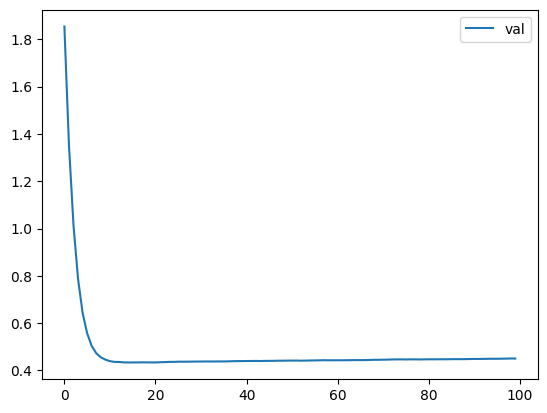

In [157]:
from matplotlib import pyplot as plt


plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.legend()

In [158]:
%%capture output

xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchList)

In [159]:
s = output.stdout

print(s)

[0]	train-rmse:2.28944	val-rmse:2.34561
[1]	train-rmse:2.07396	val-rmse:2.12434
[2]	train-rmse:1.88066	val-rmse:1.92597
[3]	train-rmse:1.70730	val-rmse:1.74987
[4]	train-rmse:1.55163	val-rmse:1.59059
[5]	train-rmse:1.41247	val-rmse:1.44988
[6]	train-rmse:1.28796	val-rmse:1.32329
[7]	train-rmse:1.17660	val-rmse:1.20930
[8]	train-rmse:1.07736	val-rmse:1.10830
[9]	train-rmse:0.98883	val-rmse:1.02009
[10]	train-rmse:0.91008	val-rmse:0.94062
[11]	train-rmse:0.84030	val-rmse:0.87100
[12]	train-rmse:0.77874	val-rmse:0.80916
[13]	train-rmse:0.72417	val-rmse:0.75465
[14]	train-rmse:0.67626	val-rmse:0.70780
[15]	train-rmse:0.63402	val-rmse:0.66672
[16]	train-rmse:0.59690	val-rmse:0.63062
[17]	train-rmse:0.56447	val-rmse:0.60016
[18]	train-rmse:0.53619	val-rmse:0.57383
[19]	train-rmse:0.51138	val-rmse:0.55044
[20]	train-rmse:0.48983	val-rmse:0.53064
[21]	train-rmse:0.47135	val-rmse:0.51451
[22]	train-rmse:0.45501	val-rmse:0.49998
[23]	train-rmse:0.44120	val-rmse:0.48790
[24]	train-rmse:0.42929	va

In [160]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pandas.DataFrame(results, columns=columns)
    return df_results


df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,2.28944,2.34561
1,1,2.07396,2.12434
2,2,1.88066,1.92597
3,3,1.70730,1.74987
4,4,1.55163,1.59059
...,...,...,...
95,95,0.30625,0.42611
96,96,0.30565,0.42621
97,97,0.30557,0.42629
98,98,0.30486,0.42629


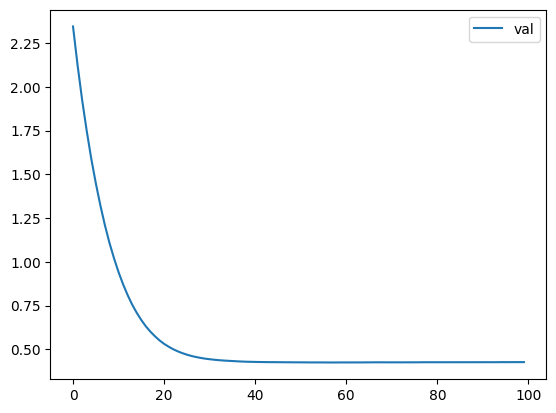

In [161]:
from matplotlib import pyplot as plt


plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.legend()